# Network Analysis on Enron email dataset

Let us load the modules that we use for this analysis

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
from itertools import groupby
import random
from tqdm import tqdm

Reading the node and edge files

In [2]:
nodes = pd.read_csv('data/id-email.csv', header=None)

In [3]:
edges = pd.read_csv('data/edges.csv')

In [4]:
nodes.shape

(6600, 2)

There are total 6599 email addresses in the dataset

In [5]:
nodes.head()

,0,1
0,0,1800flowers@shop2u.com
1,1,2000greetings@postalmanager.com
2,2,2740741@skytel.com
3,3,40ees@enron.com
4,4,40enron@enron.com


In [6]:
edges.shape

(50897, 3)

In [7]:
edges.head()

,From,To,Count
0,0,1760,3
1,2,2692,6
2,3,2719,2
3,3,3118,2
4,3,5211,2


In [8]:
edges['Count'].max()

9141

In [9]:
edges.dtypes

From     int64
To       int64
Count    int64
dtype: object

In [10]:
edges['Count'].describe()

count    50897.000000
mean         9.531426
std         55.240772
min          1.000000
25%          2.000000
50%          3.000000
75%          6.000000
max       9141.000000
Name: Count, dtype: float64

Create a grpah object from the edge list

In [11]:
enronG = nx.from_pandas_edgelist(df=edges, source='From', target='To', edge_attr=['Count'])

In [12]:
count = [i['Count'] for i in dict(enronG.edges).values()]
count_new = np.interp(count, (np.min(count), np.max(count)), (1,25))

In [13]:
np.max(count_new)

25.0

In [14]:
# Quick Snapshot of the network
print(nx.info(enronG))

Name: 
Type: Graph
Number of nodes: 6187
Number of edges: 40777
Average degree:  13.1815


Visualizing Graph might take some time

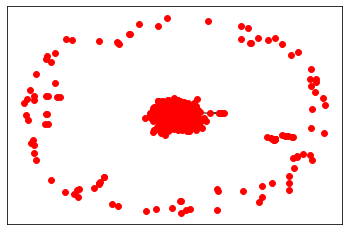

In [15]:
nx.draw_networkx(enronG, pos=nx.spring_layout(enronG), with_labels=False, node_size=35, node_color='r', width=count_new)

As we can see, there are lot small subgraphs in this network. Let us just focus on teh largest connected component

In [16]:
[len(c) for c in sorted(nx.connected_components(enronG), key=len, reverse=True)]

[6067,
 14,
 4,
 3,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

In [17]:
S = [enronG.subgraph(c).copy() for c in nx.connected_components(enronG.to_undirected())]

In [18]:
len(S[0])

6067

Largest connected Graph is with ~6k nodes

In [19]:
lcc_enron = S[0]

In [20]:
lcc_count = [i['Count'] for i in dict(S[0].edges).values()]
lcc_count_new = np.interp(lcc_count, (np.min(lcc_count), np.max(lcc_count)), (1,25))

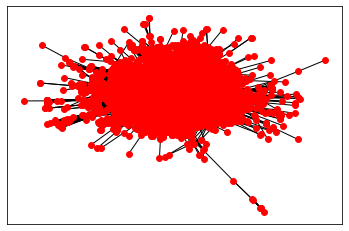

In [21]:
nx.draw_networkx(lcc_enron, pos=nx.spring_layout(lcc_enron), with_labels=False, node_size=35, node_color='r', width=lcc_count_new)

Extract local node features for all the nodes present in largest connected graph

In [22]:
g_features = pd.DataFrame({'Degree':nx.degree_centrality(lcc_enron),
                           'Closeness':nx.closeness_centrality(lcc_enron),
                           'Betweenness':nx.betweenness_centrality(lcc_enron),
                           'Eigenvector':nx.eigenvector_centrality(lcc_enron),
                           'Katz':nx.katz_centrality_numpy(lcc_enron),
                           'PageRank':nx.pagerank(lcc_enron),
                           'GlobalReaching':nx.global_reaching_centrality(lcc_enron)
})

In [23]:
g_features.head()

,Degree,Closeness,Betweenness,Eigenvector,Katz,PageRank,GlobalReaching
0,0.000165,0.239479,0.000000,0.000028,0.001028,0.000049,0.169253
1760,0.005770,0.314872,0.004390,0.001784,-0.000577,0.000889,0.169253
2,0.000330,0.289188,0.000000,0.001673,0.006718,0.000055,0.169253
2692,0.012694,0.319297,0.005364,0.006494,0.092338,0.001593,0.169253
3,0.000495,0.292000,0.000012,0.002066,-0.008103,0.000058,0.169253


Let us look at the correlations between these local graph metrics

In [24]:
corr = g_features.corr()
corr.style.background_gradient(cmap='RdYlGn').set_precision(2)

,Degree,Closeness,Betweenness,Eigenvector,Katz,PageRank,GlobalReaching
Degree,1.00,0.56,0.87,0.89,-0.04,0.99,0.00
Closeness,0.56,1.00,0.33,0.69,-0.07,0.51,0.00
Betweenness,0.87,0.33,1.00,0.68,-0.02,0.92,0.00
Eigenvector,0.89,0.69,0.68,1.00,-0.05,0.84,-0.00
Katz,-0.04,-0.07,-0.02,-0.05,1.00,-0.02,0.00
PageRank,0.99,0.51,0.92,0.84,-0.02,1.00,0.00
GlobalReaching,0.00,0.00,0.00,-0.00,0.00,0.00,1.00


We will apply an anomaly detection technique called IsolationForest to identify anomalous communication behavior based on local graph metrics

In [25]:
from sklearn.ensemble import IsolationForest
isof = IsolationForest(n_estimators=1000, max_samples='auto', contamination=0.1, 
                      max_features=1.0, bootstrap=False, n_jobs=-1,
                      random_state=2020, verbose=1, behaviour='new')
isof.fit(g_features)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   6 | elapsed:    1.2s remaining:    2.4s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:    1.2s finished


IsolationForest(behaviour='new', bootstrap=False, contamination=0.1,
                max_features=1.0, max_samples='auto', n_estimators=1000,
                n_jobs=-1, random_state=2020, verbose=1, warm_start=False)

In [26]:
anomaly_score = isof.decision_function(g_features)
anomaly_score_new = np.interp(anomaly_score, (np.min(anomaly_score), np.max(anomaly_score)), (0,1))

In [27]:
g_features['anomaly_score_new'] = anomaly_score_new

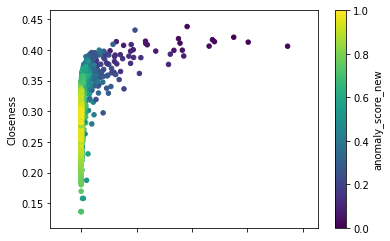

In [28]:
g_features.plot.scatter(x='Betweenness',
                       y='Closeness',
                       c='anomaly_score_new',
                       colormap='viridis')

From the above scatter plot, we cann see all teh darker points are anomalies based on Betweenness Centrality and Closeness Centrality

In [29]:
g_features = g_features.sort_values(by='anomaly_score_new', ascending=True)

In [30]:
import gc
gc.collect()

84

In [31]:
color_map = []
for node in lcc_enron:
    if node in g_features.index[-5:]:
        color_map.append('red')
    else: color_map.append('green')

In [32]:
size_map = []
for node in lcc_enron:
    if node in g_features.index[-5:]:
        size_map.append(200)
    else: size_map.append(100) 
    

Top 10 anomalies absed on all the local metrics that we calculated

In [33]:
g_features.head(10)

,Degree,Closeness,Betweenness,Eigenvector,Katz,PageRank,GlobalReaching,anomaly_score_new
6055,0.089680,0.420841,0.055051,0.161914,-0.035107,0.006277,0.169253,0.000000
5508,0.089021,0.412793,0.060268,0.145712,-0.013104,0.006971,0.169253,0.006204
5461,0.078470,0.416764,0.047374,0.139745,-0.020649,0.005012,0.169253,0.011950
2719,0.075997,0.406160,0.074481,0.101626,-0.036010,0.006386,0.169253,0.012076
6414,0.070392,0.413610,0.048093,0.112578,-0.032004,0.005085,0.169253,0.013875
3862,0.073689,0.438231,0.038231,0.181811,0.002852,0.004373,0.169253,0.018649
4072,0.071381,0.411143,0.035666,0.146828,0.013000,0.004861,0.169253,0.020344
5910,0.064952,0.418460,0.035116,0.133102,-0.008571,0.004340,0.169253,0.024351
2208,0.063963,0.406296,0.046167,0.095653,0.031617,0.004840,0.169253,0.026520
3039,0.055061,0.414373,0.023220,0.142356,0.038464,0.003356,0.169253,0.039622


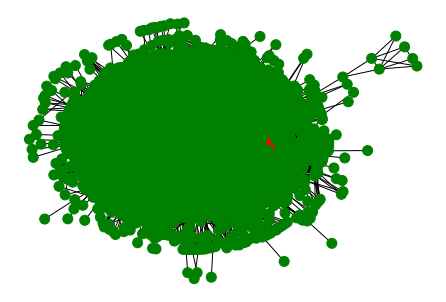

In [34]:
pos=nx.kamada_kawai_layout(lcc_enron)
nx.draw(lcc_enron, node_color = color_map, node_size=size_map, pos = pos, with_labels = False)

In [37]:
import os
os.getcwd()

'C:\\Users\\dncha\\Dropbox\\WPI\\DS504_Dingari\\DS504-exercises\\Network-Analysis'

In [38]:
nx.write_pajek(lcc_enron, "data/lcc_enron.net")

We can not really visualize those nodes that are anomalous

In [39]:
lcc_enron_small = lcc_enron.subgraph(g_features.index[0:300])

In [40]:
nx.write_pajek(lcc_enron_small, "data/lcc_enron_small.net")

In [48]:
color_map = []
for node in lcc_enron_small:
    if node in g_features.index[0:5]:
        color_map.append('red')
    else: color_map.append('green')

In [49]:
size_map = []
for node in lcc_enron_small:
    if node in g_features.index[0:5]:
        size_map.append(200)
    else: size_map.append(100)

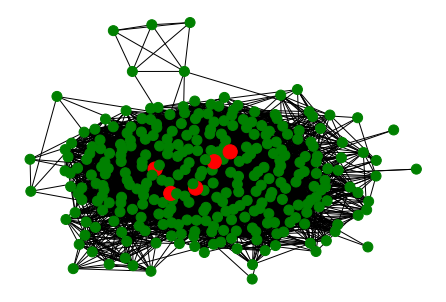

In [50]:
pos=nx.kamada_kawai_layout(lcc_enron_small)
nx.draw(lcc_enron_small, node_color = color_map, node_size=size_map, pos = pos, with_labels = False)

In [51]:
from pyvis.network import Network
net = Network("1000px", "1000px", notebook=True)

In [52]:
net.from_nx(lcc_enron_small)
# net.show_buttons(filter_=['physics'])

In [53]:
net.show('lcc_enron.html')

In [54]:
nodes.head()

,0,1
0,0,1800flowers@shop2u.com
1,1,2000greetings@postalmanager.com
2,2,2740741@skytel.com
3,3,40ees@enron.com
4,4,40enron@enron.com


In [55]:
nodes_new = nodes.reindex(g_features.index)
nodes_new['score'] = g_features['anomaly_score_new']
nodes_new = nodes_new.sort_values(by='score', ascending=True)
nodes_new.head(10)

,0,1,score
6055,6055,tana.jones@enron.com,0.000000
5508,5508,sara.shackleton@enron.com,0.006204
5461,5461,sally.beck@enron.com,0.011950
2719,2719,jeff.dasovich@enron.com,0.012076
6414,6414,vince.kaminski@enron.com,0.013875
3862,3862,louise.kitchen@enron.com,0.018649
4072,4072,mark.taylor@enron.com,0.020344
5910,5910,steven.kean@enron.com,0.024351
2208,2208,gerald.nemec@enron.com,0.026520
3039,3039,john.lavorato@enron.com,0.039622


These are top 10 anomalous communicators based on our analysis

In [56]:
nodes_new.to_csv('nodes_with_scores.csv', index=False)

Let us detect communities based on the similar patterns in emails

In [57]:
from community import community_louvain
parts = community_louvain.best_partition(lcc_enron_small)
values = [parts.get(node) for node in lcc_enron_small.nodes()]

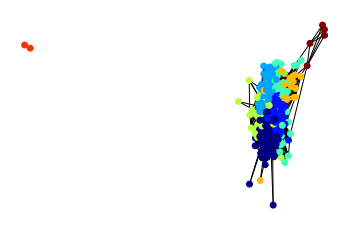

In [60]:
plt.axis("off")
spring_pos=nx.spring_layout(lcc_enron_small)
nx.draw_networkx(lcc_enron_small, pos = spring_pos, cmap = plt.get_cmap("jet"), node_color = values, node_size = 35, with_labels = False)

In [61]:
gfeatures_new = g_features.reindex(nodes.index)
gfeatures_new['Email'] = nodes[1]

In [62]:
gfeatures_new.head()

,Degree,Closeness,Betweenness,Eigenvector,Katz,PageRank,GlobalReaching,anomaly_score_new,Email
0,0.000165,0.239479,0.000000,0.000028,0.001028,0.000049,0.169253,0.917467,1800flowers@shop2u.com
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000greetings@postalmanager.com
2,0.000330,0.289188,0.000000,0.001673,0.006718,0.000055,0.169253,0.983305,2740741@skytel.com
3,0.000495,0.292000,0.000012,0.002066,-0.008103,0.000058,0.169253,0.956068,40ees@enron.com
4,0.010221,0.385878,0.005255,0.033796,0.039180,0.000663,0.169253,0.352363,40enron@enron.com


In [63]:
gfeatures_new = gfeatures_new.sort_values(by='anomaly_score_new', ascending=True)

In [64]:
gfeatures_new.head(10)

,Degree,Closeness,Betweenness,Eigenvector,Katz,PageRank,GlobalReaching,anomaly_score_new,Email
6055,0.089680,0.420841,0.055051,0.161914,-0.035107,0.006277,0.169253,0.000000,tana.jones@enron.com
5508,0.089021,0.412793,0.060268,0.145712,-0.013104,0.006971,0.169253,0.006204,sara.shackleton@enron.com
5461,0.078470,0.416764,0.047374,0.139745,-0.020649,0.005012,0.169253,0.011950,sally.beck@enron.com
2719,0.075997,0.406160,0.074481,0.101626,-0.036010,0.006386,0.169253,0.012076,jeff.dasovich@enron.com
6414,0.070392,0.413610,0.048093,0.112578,-0.032004,0.005085,0.169253,0.013875,vince.kaminski@enron.com
3862,0.073689,0.438231,0.038231,0.181811,0.002852,0.004373,0.169253,0.018649,louise.kitchen@enron.com
4072,0.071381,0.411143,0.035666,0.146828,0.013000,0.004861,0.169253,0.020344,mark.taylor@enron.com
5910,0.064952,0.418460,0.035116,0.133102,-0.008571,0.004340,0.169253,0.024351,steven.kean@enron.com
2208,0.063963,0.406296,0.046167,0.095653,0.031617,0.004840,0.169253,0.026520,gerald.nemec@enron.com
3039,0.055061,0.414373,0.023220,0.142356,0.038464,0.003356,0.169253,0.039622,john.lavorato@enron.com


In [65]:
gfeatures_new.round(2).head(10)

,Degree,Closeness,Betweenness,Eigenvector,Katz,PageRank,GlobalReaching,anomaly_score_new,Email
6055,0.09,0.42,0.06,0.16,-0.04,0.01,0.17,0.00,tana.jones@enron.com
5508,0.09,0.41,0.06,0.15,-0.01,0.01,0.17,0.01,sara.shackleton@enron.com
5461,0.08,0.42,0.05,0.14,-0.02,0.01,0.17,0.01,sally.beck@enron.com
2719,0.08,0.41,0.07,0.10,-0.04,0.01,0.17,0.01,jeff.dasovich@enron.com
6414,0.07,0.41,0.05,0.11,-0.03,0.01,0.17,0.01,vince.kaminski@enron.com
3862,0.07,0.44,0.04,0.18,0.00,0.00,0.17,0.02,louise.kitchen@enron.com
4072,0.07,0.41,0.04,0.15,0.01,0.00,0.17,0.02,mark.taylor@enron.com
5910,0.06,0.42,0.04,0.13,-0.01,0.00,0.17,0.02,steven.kean@enron.com
2208,0.06,0.41,0.05,0.10,0.03,0.00,0.17,0.03,gerald.nemec@enron.com
3039,0.06,0.41,0.02,0.14,0.04,0.00,0.17,0.04,john.lavorato@enron.com


In [71]:
print(nx.info(lcc_enron_small))

Name: 
Type: Graph
Number of nodes: 300
Number of edges: 5016
Average degree:  33.4400


Let us try to contract, by reducing the graph size based on same neighbors, which is called quotient graph

In [75]:
same_neighbors = lambda u, v: (u not in lcc_enron_small[v] and v not in lcc_enron_small[u] and lcc_enron_small[u] == lcc_enron_small[v])

In [76]:
q_enron = nx.quotient_graph(lcc_enron_small, same_neighbors)

In [77]:
print(nx.info(q_enron))

Name: 
Type: Graph
Number of nodes: 300
Number of edges: 4874
Average degree:  32.4933


In [78]:
from community import community_louvain
parts = community_louvain.best_partition(q_enron)
values = [parts.get(node) for node in q_enron.nodes()]

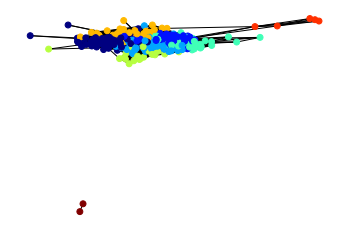

In [79]:
plt.axis("off")
spring_pos=nx.spring_layout(q_enron)
nx.draw_networkx(q_enron, pos = spring_pos, cmap = plt.get_cmap("jet"), node_color = values, node_size = 35, with_labels = False)